# Figure 7

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The notebook runs many simulations in parallel with ipyparallel to produce recurrence relations for the frost heave problem.

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
# !pip install --user ipyparallel

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import os 
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

Start ipyparallel cluster for running a bunch of examples in parallel

Change `n` in the first line to the desired number of engines

In [5]:
mycluster = ipp.Cluster(n = 20,timeout=180)
rc = mycluster.start_and_connect_sync()
view = rc.load_balanced_view()
dview = rc[:]
dview.block = True
dview.execute('import numpy as np')
dview.execute('import sys')
dview.execute('sys.path.insert(0, "../source")')
dview.execute('from wrapper import wrapper_v')

Starting 20 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/20 [00:00<?, ?engine/s]

<AsyncResult(execute): finished>

**Set timesteps for the examples in the wrapper_v function in wrapper.py**

Compute lens initiation condition for range of initial conditions:

In [6]:
from wrapper import wrapper_v

In [18]:
z_0 = np.linspace(3.9,12.1,500)     # initial lens position
v_i = 0.037                         # pulling speed
mydict = dict(v_i = v_i,z_0=z_0)
dview.push(mydict);

wrapper_ = lambda i: wrapper_v(i,v_i,z_0)
parameters = list(range(z_0.size))
async_results = []
for i in parameters:
    async_result = view.apply_async(wrapper_, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

fname = 'results-v-37.npy'
res = {'results':results,'z_0':z_0}
np.save(fname,res)

unknown:   0%|          | 0/500 [00:00<?, ?tasks/s]

Repeat for three other examples: 

In [28]:
z_0 = np.linspace(3.9,12.1,500)  
v_i = 0.0375
mydict = dict(v_i = v_i,z_0=z_0)
dview.push(mydict);
wrapper_ = lambda i: wrapper_v(i,v_i,z_0)
parameters = list(range(z_0.size))
async_results = []
for i in parameters: 
    async_result = view.apply_async(wrapper_, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

fname = 'results-v-37p5.npy'
res = {'results':results,'z_0':z_0}
np.save(fname,res)

unknown:   0%|          | 0/500 [00:00<?, ?tasks/s]

In [29]:
z_0 = np.linspace(3.9,12.1,500)  
v_i = 0.038
mydict = dict(v_i = v_i,z_0=z_0)
dview.push(mydict);
wrapper_ = lambda i: wrapper_v(i,v_i,z_0)
parameters = list(range(z_0.size))
async_results = []
for i in parameters: 
    async_result = view.apply_async(wrapper_, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

fname = 'results-v-38.npy'
res = {'results':results,'z_0':z_0}
np.save(fname,res)

unknown:   0%|          | 0/500 [00:00<?, ?tasks/s]

In [7]:
z_0 = np.linspace(3.9,12.1,500)  
z_f = np.linspace(9.94-0.05,9.94+0.075,500)
z_0 = np.append(z_0,z_f)
z_0 = np.sort(z_0)
v_i = 0.0385
mydict = dict(v_i = v_i,z_0=z_0)
dview.push(mydict);
wrapper_ = lambda i: wrapper_v(i,v_i,z_0)
parameters = list(range(z_0.size))
async_results = []
for i in parameters: 
    async_result = view.apply_async(wrapper_, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

fname = 'results-v-38p5.npy'
res = {'results':results,'z_0':z_0}
np.save(fname,res)

unknown:   0%|          | 0/1000 [00:00<?, ?tasks/s]

## Interpolate recurrence relations:

In [32]:
res = np.load('results-v-37.npy',allow_pickle=True).item()
results = res['results']
z0_1 = res['z_0']
zn_1 = np.array([])
for i in range(len(results)):
    results[i][0]
    new_lens = results[i][1]
    l = np.where(new_lens==1)
    l = np.min(l)+1
    new_lens = results[i][1][0:l]
    z_l = results[i][0][0:l]
    zn_1 = np.append(zn_1,z_l[new_lens==1])

In [33]:
res = np.load('results-v-37p5.npy',allow_pickle=True).item()
results = res['results']
z0_2 = res['z_0']
zn_2 = np.array([])
for i in range(len(results)):
    results[i][0]
    new_lens = results[i][1]
    l = np.where(new_lens==1)
    l = np.min(l)+1
    new_lens = results[i][1][0:l]
    z_l = results[i][0][0:l]
    zn_2 = np.append(zn_2,z_l[new_lens==1])

In [34]:
res = np.load('results-v-38.npy',allow_pickle=True).item()
results = res['results']
z0_3 = res['z_0']
zn_3 = np.array([])
for i in range(len(results)):
    results[i][0]
    new_lens = results[i][1]
    l = np.where(new_lens==1)
    l = np.min(l)+1
    new_lens = results[i][1][0:l]
    z_l = results[i][0][0:l]
    zn_3 = np.append(zn_3,z_l[new_lens==1])

In [35]:
res = np.load('results-v-38p5.npy',allow_pickle=True).item()
results = res['results']
z0_4 = res['z_0']

zn_4 = np.array([])
for i in range(len(results)):
    results[i][0]
    new_lens = results[i][1]
    l = np.where(new_lens==1)
    l = np.min(l)+1
    new_lens = results[i][1][0:l]
    z_l = results[i][0][0:l]
    zn_4 = np.append(zn_4,z_l[new_lens==1])

In [36]:
f_1 = interp1d(z0_1,zn_1,fill_value='extrapolate')
f_2 = interp1d(z0_2,zn_2,fill_value='extrapolate')
f_3 = interp1d(z0_3,zn_3,fill_value='extrapolate')
f_4 = interp1d(z0_4,zn_4,fill_value='extrapolate')

Find fixed points:

In [37]:
ze_1 = root_scalar(lambda z: f_1(z)-z,x0=8,x1=10,method='secant').root
ze_2 = root_scalar(lambda z: f_2(z)-z,x0=8,x1=10,method='secant').root
ze_3 = root_scalar(lambda z: f_3(z)-z,x0=8,x1=10,method='secant').root
ze_4 = root_scalar(lambda z: f_4(z)-z,x0=8,x1=10,method='secant').root

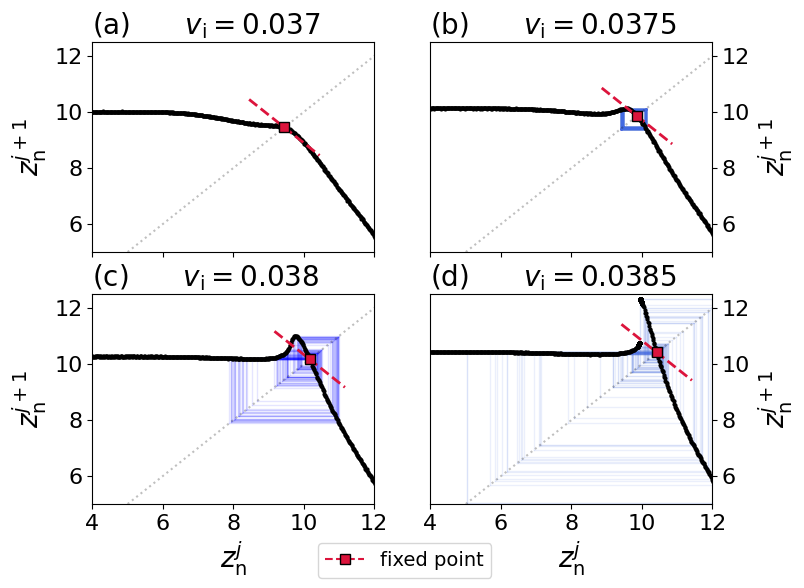

In [38]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.title(r'(a)$\qquad v_\mathrm{i} = 0.037$',fontsize=20,loc='left')
plt.plot(z0_1,zn_1,'o',color='k',markersize=2)
plt.plot(z0_1,z0_1,':',color='k',alpha=0.25)
plt.plot(np.linspace(ze_1-1,ze_1+1),np.flipud(np.linspace(ze_1-1,ze_1+1)),'--',color='crimson',linewidth=2)
plt.plot([ze_1],[ze_1],'s',color='crimson',markersize=7,markeredgecolor='k')
plt.ylabel(r'$z_\mathrm{n}^{j+1}$',fontsize=20)  
plt.gca().xaxis.set_ticklabels([])
plt.yticks(fontsize=16)
plt.xlim(4,12)
plt.ylim(5,12.5)

plt.subplot(222)
plt.title(r'(b)$\qquad v_\mathrm{i} = 0.0375$',fontsize=20,loc='left')

# # cobweb plot
#--------------------------
N = 400
x0 = 8
x, y = x0, f_2(x0)
for j in range(N):
    fy = f_2(y)  
    if j>200:
        plt.plot([x, y], [y,  y], 'royalblue', linewidth=1,alpha=0.1)
        plt.plot([y, y], [y, fy], 'royalblue', linewidth=1,alpha=0.1)
    x, y = y, fy
#--------------------------

plt.plot(z0_2,zn_2,'o',color='k',markersize=2)
plt.plot(z0_2,z0_2,':',color='k',alpha=0.25)
plt.plot(np.linspace(ze_2-1,ze_2+1),np.flipud(np.linspace(ze_2-1,ze_2+1)),'--',color='crimson',linewidth=2)
plt.plot([ze_2],[ze_2],'s',color='crimson',markersize=7,markeredgecolor='k')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel(r'$z_\mathrm{n}^{j+1}$',fontsize=20)  
plt.gca().xaxis.set_ticklabels([])
plt.yticks(fontsize=16)
plt.xlim(4,12)
plt.ylim(5,12.5)

plt.subplot(223)

#  cobweb
#--------------------------
N = 400
x0 = 8
x, y = x0, f_3(x0)
for j in range(N):
    fy = f_3(y)  
    if j>200:
        plt.plot([x, y], [y,  y], 'b', linewidth=1,alpha=0.1)
        plt.plot([y, y], [y, fy], 'b', linewidth=1,alpha=0.1)
    x, y = y, fy
#--------------------------

plt.title(r'(c)$\qquad v_\mathrm{i} = 0.038$',fontsize=20,loc='left')
plt.plot(z0_3,zn_3,'o',color='k',markersize=2)
plt.plot(z0_3,z0_3,':',color='k',alpha=0.25)
plt.plot(np.linspace(ze_3-1,ze_3+1),np.flipud(np.linspace(ze_3-1,ze_3+1)),'--',color='crimson',linewidth=2)
plt.plot([ze_3],[ze_3],'s',color='crimson',markersize=7,markeredgecolor='k')

plt.ylabel(r'$z_\mathrm{n}^{j+1}$',fontsize=20)  
plt.xlabel(r'$z_\mathrm{n}^j$',fontsize=20)  
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(4,12)
plt.ylim(5,12.5)

plt.subplot(224)

# cobweb plot
# --------------------------
N = 400
x0 = 8
x, y = x0, f_4(x0)
for j in range(N):
    fy = f_4(y)    
    if j>200:
        plt.plot([x, y], [y,  y], 'royalblue', linewidth=1,alpha=0.1)
        plt.plot([y, y], [y, fy], 'royalblue', linewidth=1,alpha=0.1)
    x, y = y, fy
# #--------------------------

plt.title(r'(d)$\qquad v_\mathrm{i} = 0.0385$',fontsize=20,loc='left')
plt.plot(z0_4,zn_4,'o',color='k',markersize=2)
plt.plot(z0_4,z0_4,':',color='k',alpha=0.25)
plt.plot(np.linspace(ze_4-1,ze_4+1),np.flipud(np.linspace(ze_4-1,ze_4+1)),'--',color='crimson',linewidth=2)
plt.plot([ze_4],[ze_4],'s--',color='crimson',markersize=7,markeredgecolor='k',label='fixed point')

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel(r'$z_\mathrm{n}^{j+1}$',fontsize=20)  
plt.xlabel(r'$z_\mathrm{n}^j$',fontsize=20)  
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14,ncol=2,loc=(-0.4,-0.35))
plt.xlim(4,12)
plt.ylim(5,12.5)
plt.savefig('Fig7',bbox_inches='tight')
plt.show()
plt.close()